LASSO REGRESSION ANALYSIS FOR NIGERIA CRASH DATA
Loading data...
Dataset shape: (518, 72)
Columns: ['Quarter', 'State', 'Total_Crashes', 'Num_Injured', 'Num_Killed', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors', 'Quarter_Num', 'Year', 'Quarter_Date', 'Total_Casualties', 'Casualty_Rate', 'Fatality_Rate', 'Vehicles_per_Crash', 'Total_Factors', 'SPV_Prop', 'DAD_Prop', 'PWR_Prop', 'FTQ_Prop', 'Other_Factors_Prop', 'Quarter_Sin', 'Quarter_Cos', 'Severe_Crash', 'High_Casualty', 'State_Encoded', 'State_Adamawa', 'State_Akwa Ibom', 'State_Anambra', 'State_Bauchi', 'State_Bayelsa', 'State_Benue', 'State_Borno', 'State_Cross River', 'State_Delta', 'State_Ebonyi', 'State_Edo', 'State_Ekiti', 'State_Enugu', 'State_FCT', 'State_Gombe', 'State_Imo', 'State_Jigawa', 'State_Kaduna', 'State_Kano', 'State_Katsina', 'State_Kebbi', 'State_Kogi', 'State_Kwara', 'State_Lagos', 'State_Nasarawa', 'State_Niger', 'State_Ogun', 'State_Ondo', 'State_Osun', 'State_Oyo', 'State_Plateau', '

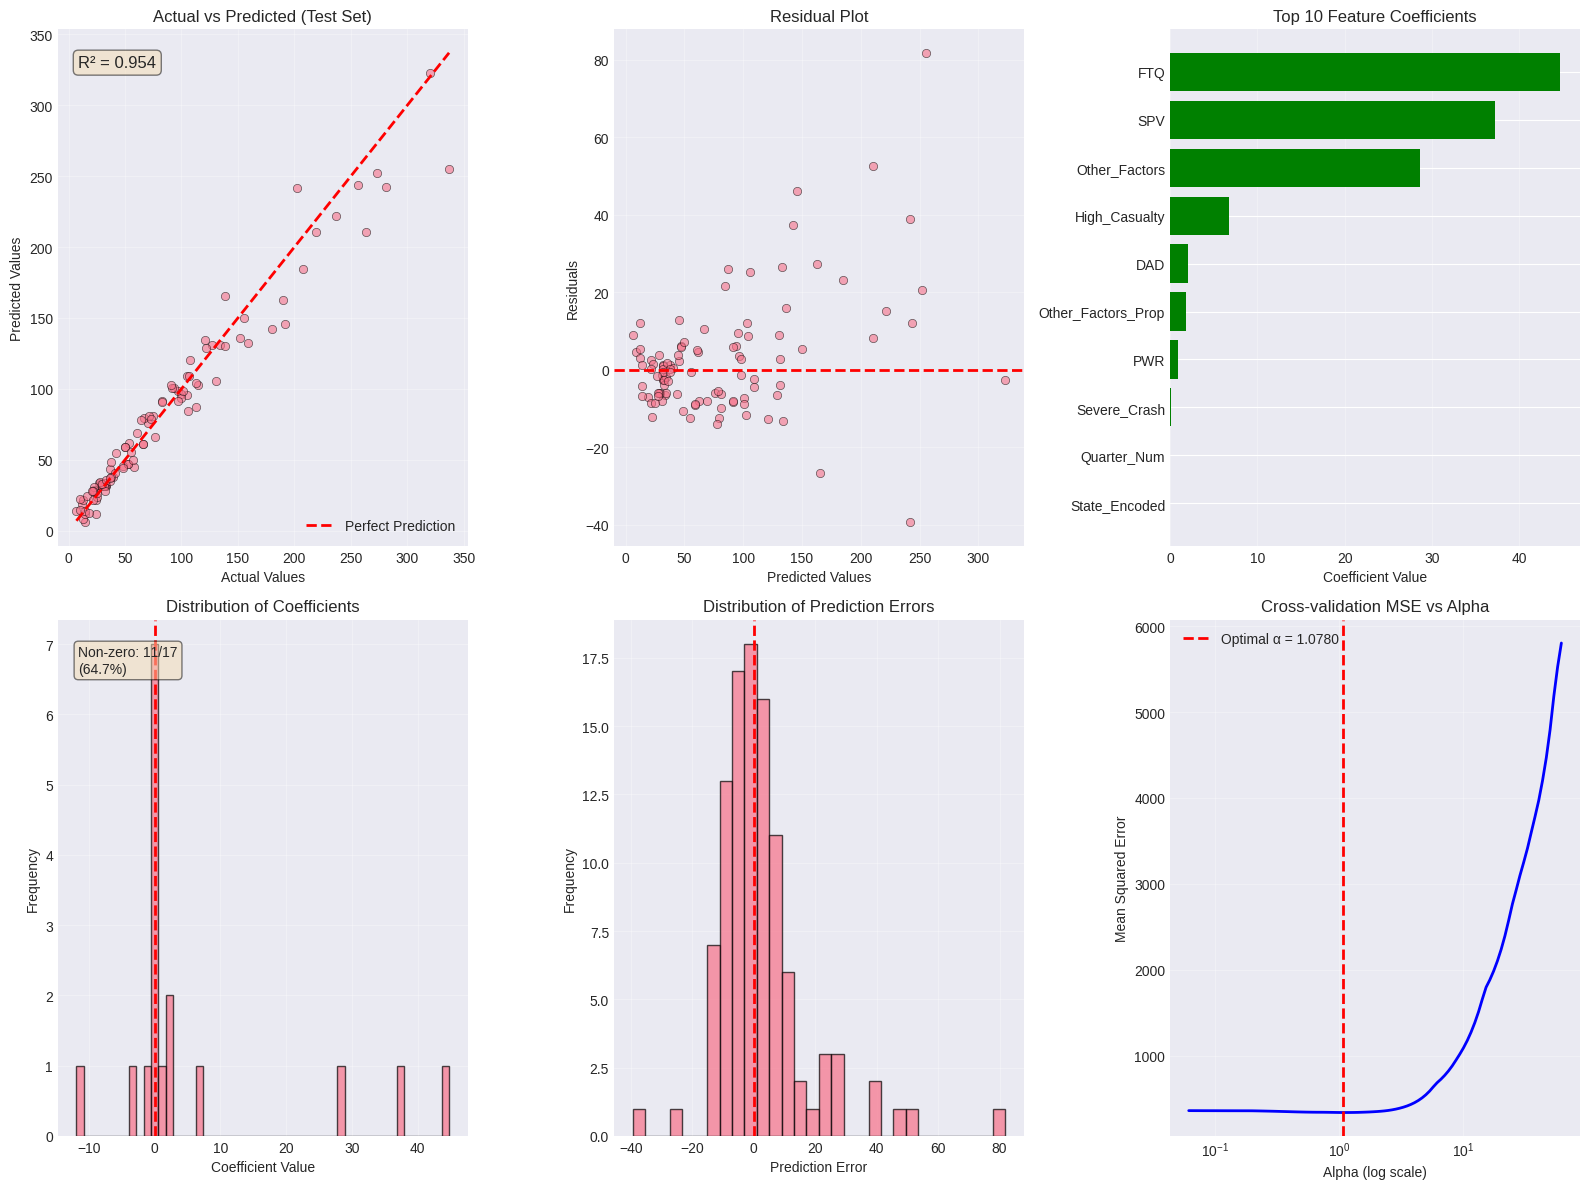


FEATURE IMPORTANCE ANALYSIS

Top 25 Most Important Features:
--------------------------------------------------------------------------------
Feature                                  Coefficient     Abs Coefficient
--------------------------------------------------------------------------------
FTQ                                      +44.746566      44.746566     
SPV                                      +37.273067      37.273067     
Other_Factors                            +28.659899      28.659899     
Vehicles_per_Crash                       -11.874248      11.874248     
High_Casualty                            +6.731047       6.731047      
FTQ_Prop                                 -3.363506       3.363506      
DAD                                      +2.028063       2.028063      
Other_Factors_Prop                       +1.781313       1.781313      
PWR                                      +0.918196       0.918196      
Year                                     -0.627487     

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def load_and_prepare_data(file_path='Nigeria Crash Data P.csv'):
    """
    Load and prepare the crash data for analysis
    """
    print("Loading data...")
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Display basic info
    print("\nData types:")
    print(df.dtypes.value_counts())

    print("\nMissing values summary:")
    print(f"Total missing values: {df.isnull().sum().sum()}")

    return df

def explore_target_variables(df):
    """
    Explore potential target variables
    """
    print("\n" + "="*60)
    print("TARGET VARIABLE OPTIONS")
    print("="*60)

    target_options = [
        'Total_Crashes', 'Num_Injured', 'Num_Killed',
        'Total_Casualties', 'Casualty_Rate', 'Fatality_Rate',
        'Total_Vehicles_Involved'
    ]

    print("\nSummary statistics for potential targets:")
    for target in target_options:
        if target in df.columns:
            print(f"\n{target}:")
            print(f"  Mean: {df[target].mean():.2f}")
            print(f"  Std: {df[target].std():.2f}")
            print(f"  Min: {df[target].min():.2f}")
            print(f"  Max: {df[target].max():.2f}")

    return target_options

def prepare_features_target(df, target_column='Total_Crashes'):
    """
    Prepare features and target variable for modeling
    """
    print(f"\nPreparing data for target: {target_column}")

    # Identify columns to exclude
    identifier_cols = ['Quarter', 'State', 'Quarter_Date', 'Region']

    # Additional columns that might cause leakage or are not useful
    problematic_cols = [
        'Total_Casualties', 'Casualty_Rate', 'Fatality_Rate',
        'Total_Factors', 'Quarter_Sin', 'Quarter_Cos'
    ]

    # Combine all columns to exclude
    exclude_cols = identifier_cols + problematic_cols

    # Don't exclude the target itself from problematic_cols
    if target_column in exclude_cols:
        exclude_cols.remove(target_column)

    # Also exclude other potential targets to avoid leakage
    other_targets = ['Num_Injured', 'Num_Killed', 'Total_Vehicles_Involved']
    for ot in other_targets:
        if ot != target_column and ot in df.columns and ot not in exclude_cols:
            exclude_cols.append(ot)

    # Select numeric feature columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col not in exclude_cols and col != target_column]

    print(f"Number of features: {len(feature_cols)}")
    print(f"Number of samples: {len(df)}")

    # Prepare X and y
    X = df[feature_cols].copy()
    y = df[target_column].copy()

    return X, y, feature_cols

def apply_lasso_regression(X, y, alpha=0.1, test_size=0.2, random_state=42):
    """
    Apply Lasso regression with the specified parameters
    """
    print("\n" + "="*60)
    print("APPLYING LASSO REGRESSION")
    print("="*60)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")

    # Standardize features (important for Lasso)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train Lasso model
    lasso = Lasso(alpha=alpha, random_state=random_state, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = lasso.predict(X_train_scaled)
    y_pred_test = lasso.predict(X_test_scaled)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Display results
    print("\nModel Performance:")
    print("-" * 40)
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")

    # Feature analysis
    n_nonzero = np.sum(lasso.coef_ != 0)
    n_zero = np.sum(lasso.coef_ == 0)
    print(f"\nFeature Selection Results:")
    print(f"Features with non-zero coefficients: {n_nonzero}")
    print(f"Features shrunk to zero: {n_zero}")
    print(f"Sparsity: {(n_zero / len(lasso.coef_) * 100):.2f}%")

    return {
        'model': lasso,
        'scaler': scaler,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'feature_names': X.columns.tolist()
    }

def perform_feature_analysis(results, top_n=20):
    """
    Analyze and display feature importance from Lasso model
    """
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    lasso = results['model']
    feature_names = results['feature_names']

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': lasso.coef_,
        'Absolute_Coefficient': np.abs(lasso.coef_)
    })

    # Sort by absolute coefficient
    feature_importance = feature_importance.sort_values('Absolute_Coefficient', ascending=False)

    # Display top features
    print(f"\nTop {top_n} Most Important Features:")
    print("-" * 80)
    print(f"{'Feature':<40} {'Coefficient':<15} {'Abs Coefficient':<15}")
    print("-" * 80)

    for i, row in feature_importance.head(top_n).iterrows():
        coef_sign = '+' if row['Coefficient'] >= 0 else '-'
        print(f"{row['Feature']:<40} {coef_sign}{abs(row['Coefficient']):<14.6f} {row['Absolute_Coefficient']:<14.6f}")

    # Analyze zero coefficients
    zero_features = feature_importance[feature_importance['Coefficient'] == 0]
    if len(zero_features) > 0:
        print(f"\nNumber of features with zero coefficient: {len(zero_features)}")
        print("First 10 features with zero coefficient:")
        for feature in zero_features['Feature'].head(10):
            print(f"  - {feature}")

    return feature_importance

def cross_validate_lasso(X, y, cv=5, random_state=42):
    """
    Perform cross-validation to find optimal alpha
    """
    print("\n" + "="*60)
    print("LASSO CROSS-VALIDATION FOR OPTIMAL ALPHA")
    print("="*60)

    # Standardize the entire feature set for CV
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform LassoCV
    lasso_cv = LassoCV(cv=cv, random_state=random_state, max_iter=10000)
    lasso_cv.fit(X_scaled, y)

    print(f"Optimal alpha from cross-validation: {lasso_cv.alpha_:.6f}")

    # Get cross-validation scores
    mse_path_mean = np.mean(lasso_cv.mse_path_, axis=1)
    alphas = lasso_cv.alphas_

    # Find the best alpha index
    best_alpha_idx = np.argmin(mse_path_mean)

    return {
        'optimal_alpha': lasso_cv.alpha_,
        'alphas': alphas,
        'mse_path': lasso_cv.mse_path_,
        'mse_path_mean': mse_path_mean,
        'best_alpha_idx': best_alpha_idx,
        'model_cv': lasso_cv
    }

def visualize_results(results, cv_results=None):
    """
    Create visualizations for Lasso results
    """
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS")
    print("="*60)

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Actual vs Predicted (Test Set)
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(results['y_test'], results['y_pred_test'], alpha=0.6, edgecolors='k', linewidth=0.5)
    ax1.plot([results['y_test'].min(), results['y_test'].max()],
             [results['y_test'].min(), results['y_test'].max()],
             'r--', lw=2, label='Perfect Prediction')
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Actual vs Predicted (Test Set)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add R² text
    ax1.text(0.05, 0.95, f'R² = {results["test_r2"]:.3f}',
             transform=ax1.transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. Residual Plot
    ax2 = plt.subplot(2, 3, 2)
    residuals = results['y_test'] - results['y_pred_test']
    ax2.scatter(results['y_pred_test'], residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)

    # 3. Top Feature Coefficients
    ax3 = plt.subplot(2, 3, 3)
    feature_importance = pd.DataFrame({
        'Feature': results['feature_names'],
        'Coefficient': results['model'].coef_
    })
    feature_importance = feature_importance.sort_values('Coefficient', ascending=False)
    top_features = feature_importance.head(10)

    colors = ['green' if c > 0 else 'red' for c in top_features['Coefficient']]
    y_pos = np.arange(len(top_features))
    ax3.barh(y_pos, top_features['Coefficient'], color=colors)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(top_features['Feature'])
    ax3.invert_yaxis()
    ax3.set_xlabel('Coefficient Value')
    ax3.set_title('Top 10 Feature Coefficients')
    ax3.grid(True, alpha=0.3, axis='x')

    # 4. Coefficient Distribution
    ax4 = plt.subplot(2, 3, 4)
    coefficients = results['model'].coef_
    ax4.hist(coefficients, bins=50, edgecolor='black', alpha=0.7)
    ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax4.set_xlabel('Coefficient Value')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Coefficients')
    ax4.grid(True, alpha=0.3)

    # Add statistics text
    n_nonzero = np.sum(coefficients != 0)
    n_total = len(coefficients)
    ax4.text(0.05, 0.95, f'Non-zero: {n_nonzero}/{n_total}\n({n_nonzero/n_total*100:.1f}%)',
             transform=ax4.transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 5. Prediction Error Distribution
    ax5 = plt.subplot(2, 3, 5)
    prediction_errors = results['y_test'] - results['y_pred_test']
    ax5.hist(prediction_errors, bins=30, edgecolor='black', alpha=0.7)
    ax5.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax5.set_xlabel('Prediction Error')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Distribution of Prediction Errors')
    ax5.grid(True, alpha=0.3)

    # 6. Cross-validation MSE path (if available)
    if cv_results is not None:
        ax6 = plt.subplot(2, 3, 6)
        ax6.semilogx(cv_results['alphas'], cv_results['mse_path_mean'], 'b-', linewidth=2)
        ax6.axvline(cv_results['optimal_alpha'], color='r', linestyle='--',
                   linewidth=2, label=f'Optimal α = {cv_results["optimal_alpha"]:.4f}')
        ax6.set_xlabel('Alpha (log scale)')
        ax6.set_ylabel('Mean Squared Error')
        ax6.set_title('Cross-validation MSE vs Alpha')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    else:
        # If no CV results, show training vs testing performance
        ax6 = plt.subplot(2, 3, 6)
        metrics = ['R²', 'RMSE', 'MAE']
        train_values = [results['train_r2'], results['train_rmse'], results['train_mae']]
        test_values = [results['test_r2'], results['test_rmse'], results['test_mae']]

        x = np.arange(len(metrics))
        width = 0.35

        ax6.bar(x - width/2, train_values, width, label='Training', alpha=0.8)
        ax6.bar(x + width/2, test_values, width, label='Testing', alpha=0.8)

        ax6.set_xlabel('Metric')
        ax6.set_ylabel('Value')
        ax6.set_title('Training vs Testing Performance')
        ax6.set_xticks(x)
        ax6.set_xticklabels(metrics)
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('lasso_results_visualization.png', dpi=300, bbox_inches='tight')
    print("Visualizations saved as 'lasso_results_visualization.png'")
    plt.show()

    return fig

def save_model_and_results(results, feature_importance, filename_prefix='lasso_crash'):
    """
    Save the trained model, scaler, and results
    """
    print("\n" + "="*60)
    print("SAVING MODEL AND RESULTS")
    print("="*60)

    # Save model
    model_filename = f'{filename_prefix}_model.joblib'
    joblib.dump(results['model'], model_filename)
    print(f"Model saved as: {model_filename}")

    # Save scaler
    scaler_filename = f'{filename_prefix}_scaler.joblib'
    joblib.dump(results['scaler'], scaler_filename)
    print(f"Scaler saved as: {scaler_filename}")

    # Save feature importance
    feature_filename = f'{filename_prefix}_feature_importance.csv'
    feature_importance.to_csv(feature_filename, index=False)
    print(f"Feature importance saved as: {feature_filename}")

    # Save performance metrics
    metrics = {
        'train_r2': results['train_r2'],
        'test_r2': results['test_r2'],
        'train_rmse': results['train_rmse'],
        'test_rmse': results['test_rmse'],
        'train_mae': results.get('train_mae', None),
        'test_mae': results.get('test_mae', None),
        'n_features': len(results['feature_names']),
        'n_nonzero_features': np.sum(results['model'].coef_ != 0),
        'sparsity': np.sum(results['model'].coef_ == 0) / len(results['model'].coef_)
    }

    metrics_df = pd.DataFrame([metrics])
    metrics_filename = f'{filename_prefix}_metrics.csv'
    metrics_df.to_csv(metrics_filename, index=False)
    print(f"Metrics saved as: {metrics_filename}")

    # Save predictions
    predictions_df = pd.DataFrame({
        'y_actual': results['y_test'],
        'y_predicted': results['y_pred_test'],
        'residual': results['y_test'] - results['y_pred_test']
    })
    predictions_filename = f'{filename_prefix}_predictions.csv'
    predictions_df.to_csv(predictions_filename, index=False)
    print(f"Predictions saved as: {predictions_filename}")

    return {
        'model_file': model_filename,
        'scaler_file': scaler_filename,
        'feature_file': feature_filename,
        'metrics_file': metrics_filename,
        'predictions_file': predictions_filename
    }

def main():
    """
    Main function to run the complete Lasso analysis
    """
    print("="*70)
    print("LASSO REGRESSION ANALYSIS FOR NIGERIA CRASH DATA")
    print("="*70)

    # Step 1: Load data
    df = load_and_prepare_data('Nigeria Crash Data P.csv')

    # Step 2: Explore target options
    target_options = explore_target_variables(df)

    # Step 3: Choose target (modify this as needed)
    target_column = 'Total_Crashes'  # Can change to other targets

    # Step 4: Prepare features and target
    X, y, feature_names = prepare_features_target(df, target_column)

    # Step 5: Apply Lasso regression
    results = apply_lasso_regression(X, y, alpha=0.1, test_size=0.2, random_state=42)
    results['feature_names'] = feature_names

    # Step 6: Perform feature analysis
    feature_importance = perform_feature_analysis(results, top_n=25)

    # Step 7: Cross-validation for optimal alpha
    cv_results = cross_validate_lasso(X, y, cv=5, random_state=42)

    # Step 8: Train model with optimal alpha
    print("\n" + "="*60)
    print("TRAINING MODEL WITH OPTIMAL ALPHA")
    print("="*60)

    optimal_results = apply_lasso_regression(
        X, y,
        alpha=cv_results['optimal_alpha'],
        test_size=0.2,
        random_state=42
    )
    optimal_results['feature_names'] = feature_names

    # Step 9: Visualize results
    visualize_results(optimal_results, cv_results)

    # Step 10: Perform feature analysis for optimal model
    optimal_feature_importance = perform_feature_analysis(optimal_results, top_n=25)

    # Step 11: Save model and results
    saved_files = save_model_and_results(optimal_results, optimal_feature_importance,
                                        filename_prefix=f'lasso_{target_column.lower()}')

    # Step 12: Summary report
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - SUMMARY")
    print("="*70)
    print(f"Target variable: {target_column}")
    print(f"Optimal alpha: {cv_results['optimal_alpha']:.6f}")
    print(f"Final model R² (test): {optimal_results['test_r2']:.4f}")
    print(f"Final model RMSE (test): {optimal_results['test_rmse']:.4f}")
    print(f"Number of features used: {np.sum(optimal_results['model'].coef_ != 0)}")
    print(f"Model sparsity: {(np.sum(optimal_results['model'].coef_ == 0) / len(optimal_results['model'].coef_) * 100):.1f}%")

    print("\nTop 5 most important features:")
    top_features = optimal_feature_importance.head(5)
    for idx, row in top_features.iterrows():
        direction = "increases" if row['Coefficient'] > 0 else "decreases"
        print(f"  {row['Feature']}: {direction} {target_column} (coefficient: {row['Coefficient']:.4f})")

    print("\nFiles created:")
    for key, value in saved_files.items():
        print(f"  - {value}")

    print("\n" + "="*70)

if __name__ == "__main__":
    main()